# Decoding MEG/EEG data
### -- A bonus episode to PracticalMEEG 2022 --

`Authors: Britta Westner, Alexandre Gramfort`


Let's see if we can do some _single trial_ decoding of our data (dataset #1)! 

For that, we will use the MNE-Python decoding module, which makes use of the extensive machine learning library and toolbox [scikit-learn](https://scikit-learn.org/stable/).

`
Reference:
Scikit-learn: Machine Learning in Python,
Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
`

In [27]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import mne
import numpy as np

## Load the epochs we saved

In [28]:
mne.set_log_level('error')

# Change the following path to where the folder ds000117 is on your disk
data_path = os.path.expanduser("~/Documents/teaching/practical_meeg_2022_data/ds000117")

epochs_fname = os.path.join(data_path,
    'derivatives/meg_derivatives/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_proc-sss-epo.fif')

In [45]:
epochs = mne.read_epochs(epochs_fname)
epochs.crop(-0.3, 0.4)
epochs.pick_types('grad')  # let's only keep the gradiometers this time

Number of events,145
Events,face/famous/first: 24face/famous/immediate: 10face/famous/long: 14face/unfamiliar/first: 25face/unfamiliar/immediate: 12face/unfamiliar/long: 10scrambled/first: 25scrambled/immediate: 14scrambled/long: 11
Time range,-0.300 – 0.400 sec
Baseline,-0.200 – 0.000 sec


Let's compute the ERFs and look at the contrast between _face_ and _scrambled_ responses.

In [43]:
evoked_face = epochs['face'].average()
evoked_scrambled = epochs['scrambled'].average()
evoked_contrast = mne.combine_evoked([evoked_face, evoked_scrambled],
                                     [0.5, -0.5])

Let's check the signal ...

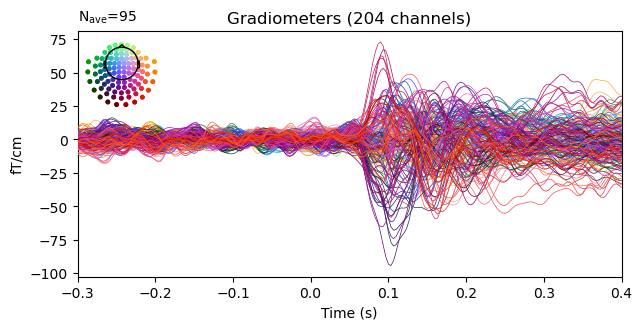

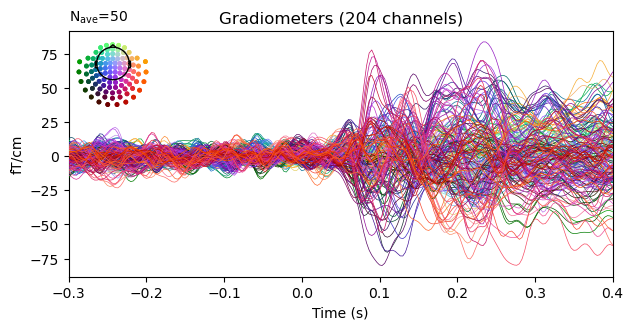

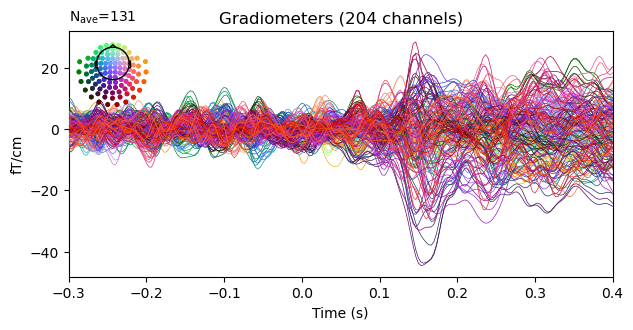

In [46]:
evoked_face.plot();
evoked_scrambled.plot();
evoked_contrast.plot();

... and plot some topographies:

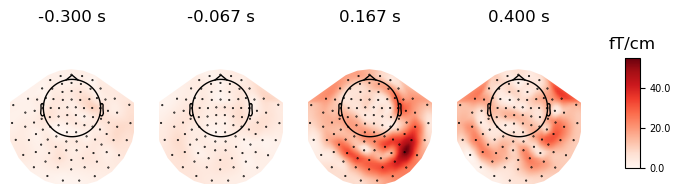

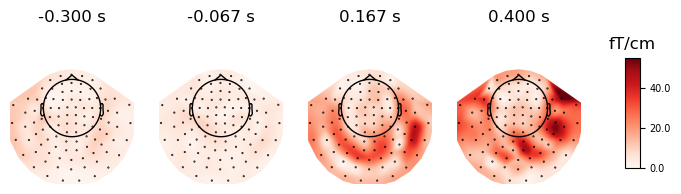

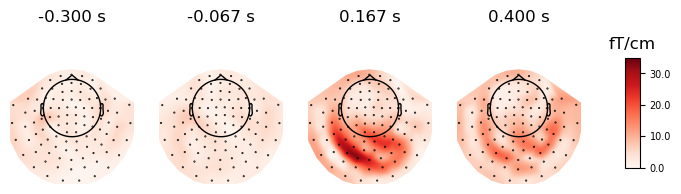

In [49]:
vmax = 55
evoked_face.plot_topomap(contours=0, vmin=0, vmax=vmax);
evoked_scrambled.plot_topomap(contours=0, vmin=0, vmax=vmax);

vmax = 35
evoked_contrast.plot_topomap(contours=0, vmin=0, vmax=vmax);

## Let's prepare our data for classification

First, we equalize the trials per condition, so 50% is actually our chance level:

In [50]:
epochs.equalize_event_counts(['face', 'scrambled'])

(<EpochsFIF |  100 events (all good), -0.3 - 0.4 sec, baseline -0.2 – 0 sec, ~39.7 MB, data loaded,
  'face/famous/first': 12
  'face/famous/immediate': 7
  'face/famous/long': 10
  'face/unfamiliar/first': 10
  'face/unfamiliar/immediate': 7
  'face/unfamiliar/long': 4
  'scrambled/first': 25
  'scrambled/immediate': 14
  'scrambled/long': 11>,
 array([  0,   1,   2,   3,   4,   5,   6,   9,  10,  11,  12,  13,  24,
         27,  28,  29,  58,  59,  64,  65,  66,  69,  70, 107, 108, 109,
        112, 113, 120, 121, 122, 123, 124, 125, 126, 127, 136, 137, 138,
        139, 140, 141, 142, 143, 144]))

For classification, we first need a _response_ vector. In our case, that is a vector that describes for each trial, whether the trial was 
a _face_ or a _scrambled_ trial. 

We set _face_ to 1, and _scrambled_ to 0.

In [51]:
# initialize with zeros and then set faces to 1
y = np.zeros(len(epochs.events), dtype=int)
y[epochs.events[:, 2] < 17] = 1  # 1 means face

y.size # check the length

100

We also need an array that contains our data (_observations x channels x time_):

In [53]:
X = epochs.get_data()
X.shape

(100, 204, 211)

## Let's see if we can classify the data based on single trials

In [54]:
# we use a logistic regression model and import this from scikit learn:
from sklearn.linear_model import LogisticRegression

# We then set the parameters (regularization value and solver):
logreg = LogisticRegression(C=1e6, solver='liblinear')

Let's use the `mne.decoding` module to manage our classification:

In [55]:
from sklearn.pipeline import make_pipeline
from mne.decoding import Scaler, Vectorizer, cross_val_multiscore

# We make a pipeline object that specifies how to handle the data:
clf = make_pipeline(Scaler(epochs.info),
                    Vectorizer(),
                    logreg)

# Now let's run the classification and score based on a 5-fold-cross-validation:
scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=1)

# Let's compute the mean scores across cross-validation splits:
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))

Spatio-temporal: 91.0%


## Decoding over time

Often more interesting for electrophysiological data is to keep the time dimension and to slide
the decoding model across time:

In [56]:
from sklearn.preprocessing import StandardScaler
from mne.decoding import SlidingEstimator

# We prepare our pipeline again:
clf = make_pipeline(StandardScaler(), logreg)

# But now wrap this pipeline in a sliding estimator:
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)

# Let's score it:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits:
scores = np.mean(scores, axis=0)

# Let's see the dimesion of our scores:
scores.shape


(211,)

We kept the time dimension - by fitting one model per time-point. Let's plot our scores!

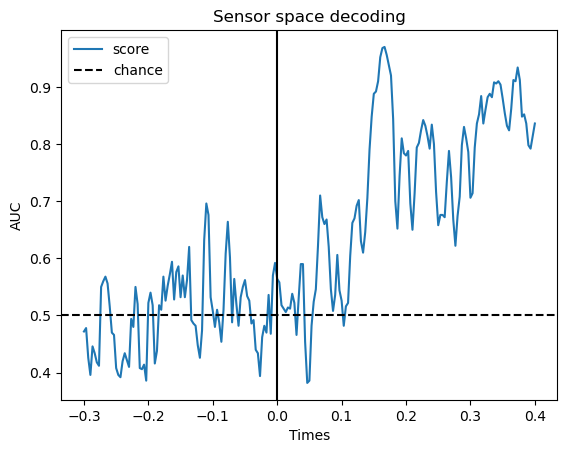

In [57]:
# prepare plot
fig, ax = plt.subplots()

# plot scores and chance level
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.axvline(.0, color='k', linestyle='-')  # mark time 0

# set axis labels, legend, title
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()

ax.set_title('Sensor space decoding')

plt.show()

## Further reading

For more details see: https://mne.tools/stable/auto_tutorials/machine-learning/plot_sensors_decoding.html
See more info on decoding on this page: https://mne.tools/stable/auto_tutorials/machine-learning/plot_sensors_decoding.html
and this book chapter:

Jean-Rémi King, Laura Gwilliams, Chris Holdgraf, Jona Sassenhagen, Alexandre Barachant, Denis Engemann, Eric Larson, Alexandre Gramfort. Encoding and Decoding Neuronal Dynamics: Methodological Framework to Uncover the Algorithms of Cognition. 2018. https://hal.archives-ouvertes.fr/hal-01848442/